


<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

- ## Imports

In [1]:
import time
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


- ## Reading Data

In [2]:
d1 = pd.read_csv('datasets/training_variants',index_col='ID')
d2 = pd.read_csv('datasets/training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1,index_col='ID') # to know more about the engine visit the documnetation for .read_csv() also sep="\|\|" as the seperatop for this text file is || 
data = pd.concat([d1,d2],axis=1)

In [3]:
data.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Int64Index: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3321 non-null   object
 1   Variation  3321 non-null   object
 2   Class      3321 non-null   int64 
 3   TEXT       3316 non-null   object
dtypes: int64(1), object(3)
memory usage: 129.7+ KB


In [4]:
data[data.isna().any(axis=1)] # here any() searches for any true value in the columns but any(1) searches for true values in each row

,Gene,Variation,Class,TEXT
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


We are not goinng to fill the missing nan values as we have taken care of the nan value sin the text preprosessing function

In [5]:
data['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
IL7R        1
EIF1AX      1
STAG2       1
TCF7L2      1
CDK8        1
Name: Gene, Length: 264, dtype: int64

In [6]:
data['Variation'].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
G14V                     1
A500T                    1
R1097H                   1
M1255I                   1
N71K                     1
Name: Variation, Length: 2996, dtype: int64

In [7]:
data['Class'].value_counts(normalize=True)

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: Class, dtype: float64

&lt;AxesSubplot:ylabel=&#39;Class&#39;&gt;

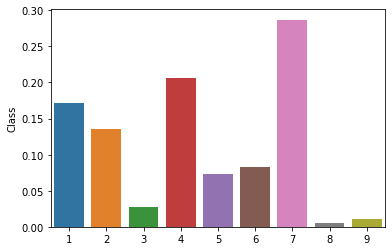

In [8]:
sns.barplot(data['Class'].value_counts(normalize=True).index,data['Class'].value_counts(normalize=True))

- ## Text Preprocessing

In [9]:
STOP_WORDS = stopwords.words('english')
def TextPreprocessing(txt):
    if str(txt) != 'nan':
        txt = re.sub(r'[^A-Za-z0-9]+',' ',txt)
        txt = re.sub('\s+',' ',txt)
        txt = txt.lower()
        wrds = [w for w in txt.split() if w not in STOP_WORDS]
        txt_str = ' '.join(str(e) for e in wrds)
        return txt_str
    else: return ' '

In [10]:
start_time = time.time()
data['txt'] = data['TEXT'].apply(TextPreprocessing)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

Time took for preprocessing the text : 87.30446600914001 seconds


In [11]:
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

- ## Train Test CV split {64,20,16} 
 Randomly

In [87]:
trainX,testx,trainY,testy = train_test_split(data.drop(['TEXT'],axis=1),data['Class'],stratify=data['Class'],test_size=0.2)
trainx,cvx,trainy,cvy = train_test_split(trainX,trainY,stratify=trainY,test_size=0.2)

In [88]:
trainy.value_counts(normalize=True),testy.value_counts(normalize=True),cvy.value_counts(normalize=True)

(7    0.286723
 4    0.206685
 1    0.170904
 2    0.136064
 6    0.082863
 5    0.072976
 3    0.026836
 9    0.011299
 8    0.005650
 Name: Class, dtype: float64,
 7    0.287218
 4    0.206015
 1    0.171429
 2    0.136842
 6    0.082707
 5    0.072180
 3    0.027068
 9    0.010526
 8    0.006015
 Name: Class, dtype: float64,
 7    0.287594
 4    0.206767
 1    0.171053
 2    0.135338
 6    0.082707
 5    0.073308
 3    0.026316
 9    0.011278
 8    0.005639
 Name: Class, dtype: float64)

In [89]:
trainy.shape,testy.shape,cvy.shape

((2124,), (665,), (532,))

- # Univariante Analysis

## 1)Genes

In [15]:
data['Gene'].describe(),data['Gene'].value_counts()

(count      3321
 unique      264
 top       BRCA1
 freq        264
 Name: Gene, dtype: object,
 BRCA1     264
 TP53      163
 EGFR      141
 PTEN      126
 BRCA2     125
          ... 
 IL7R        1
 EIF1AX      1
 STAG2       1
 TCF7L2      1
 CDK8        1
 Name: Gene, Length: 264, dtype: int64)

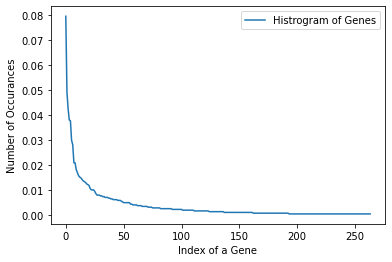

In [16]:
plt.plot(data['Gene'].value_counts(normalize=True).to_numpy(),label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> As we can see the above distribution is right skewed and also very first few genes occur large times than the rest of other

- ### CDF Distribution

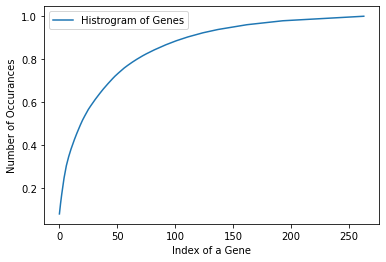

In [17]:
plt.plot(np.cumsum(data['Gene'].value_counts(normalize=True).to_numpy()),label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> as we can see here with only first most occuring 50 Genes almost 80% of data gets covered

- ### Now to vectorize the Categorical variable we have two options:
<h3> 1) One Hot Encoding <br>
2)Response Coding </h3>

Here First we will try response coding

In [90]:
def getResProbs(grp_col,a): # A stands for alpha in Laplace Smoothing
    temp = grp_col.value_counts()
    res_cols = list()
    tot = temp.sum()
    for i in range(1,10):
        if i not in temp.index:
            res_cols.append((10*a)/(tot+(90*a)))
        else:
            res_cols.append((temp[i]+(10*a))/(tot+(90*a)))
    return res_cols

res_dict = dict(trainx.groupby('Gene')['Class'].apply(lambda x:getResProbs(x,1)))

def mappResDict(x,dict):
    if x in dict.keys():
        return dict[x]
    else:
        return [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]

In [104]:
train_gene_response=pd.DataFrame(list(trainx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=trainx.index,columns=list(range(1,10)))
test_gene_response = pd.DataFrame(list(testx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=testx.index,columns=list(range(1,10)))
cv_gene_response = pd.DataFrame(list(cvx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=cvx.index,columns=list(range(1,10)))